In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data_D.csv', delimiter=',')

In [3]:
df.head()

,Unnamed: 0,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
0,0,106473,15639576,Sarratt,652.0,France,Female,65.0,3,0.00,2,1,1,136592.24,0
1,1,62345,15769582,Hanson,464.0,France,Male,35.0,4,0.00,1,0,0,99505.75,1
2,2,126615,15675888,Austin,620.0,Germany,Female,39.0,6,129401.87,2,1,1,102681.32,1
3,3,35909,15786617,Tuan,598.0,France,Female,30.0,7,0.00,2,1,0,141210.18,0
4,4,45175,15757310,Li Fonti,682.0,Germany,Female,46.0,4,107720.57,1,0,0,93832.33,1


In [4]:
df.shape

(41259, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41259 entries, 0 to 41258
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       41259 non-null  int64  
 1   id               41259 non-null  int64  
 2   CustomerId       41259 non-null  int64  
 3   Surname          41259 non-null  object 
 4   CreditScore      41251 non-null  float64
 5   Geography        41259 non-null  object 
 6   Gender           41259 non-null  object 
 7   Age              41259 non-null  float64
 8   Tenure           41259 non-null  int64  
 9   Balance          41259 non-null  float64
 10  NumOfProducts    41259 non-null  int64  
 11  HasCrCard        41259 non-null  int64  
 12  IsActiveMember   41259 non-null  int64  
 13  EstimatedSalary  41259 non-null  float64
 14  churn            41259 non-null  int64  
dtypes: float64(4), int64(8), object(3)
memory usage: 4.7+ MB


In [6]:
df.columns

Index(['Unnamed: 0', 'id', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'churn'],
      dtype='object')

In [7]:
df.drop(['Unnamed: 0', 'id', 'CustomerId', 'Surname'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41259 entries, 0 to 41258
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      41251 non-null  float64
 1   Geography        41259 non-null  object 
 2   Gender           41259 non-null  object 
 3   Age              41259 non-null  float64
 4   Tenure           41259 non-null  int64  
 5   Balance          41259 non-null  float64
 6   NumOfProducts    41259 non-null  int64  
 7   HasCrCard        41259 non-null  int64  
 8   IsActiveMember   41259 non-null  int64  
 9   EstimatedSalary  41259 non-null  float64
 10  churn            41259 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 3.5+ MB


In [8]:
print(df.isnull().sum())

CreditScore        8
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
churn              0
dtype: int64


upper bound: 878.0
lower bound: 430.0


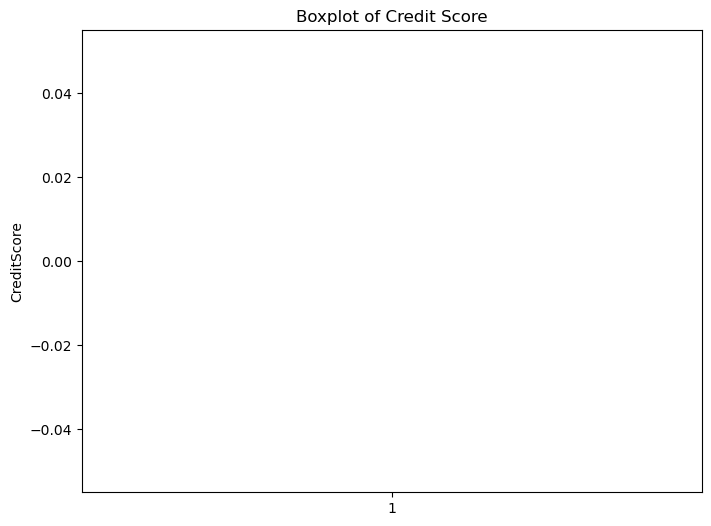

In [9]:
plt.figure(figsize=(8,6))
plt.boxplot(df['CreditScore'])
plt.title('Boxplot of Credit Score')
plt.ylabel('CreditScore')

q1 = df['CreditScore'].quantile(0.25)
q3 = df['CreditScore'].quantile(0.75)
IQR = q3 - q1
upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print("upper bound:", upper_bound)
print("lower bound:", lower_bound)
plt.show()

In [10]:
df.dropna(subset=['CreditScore'], inplace = True)

In [11]:
print(df.isna().sum())

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
churn              0
dtype: int64


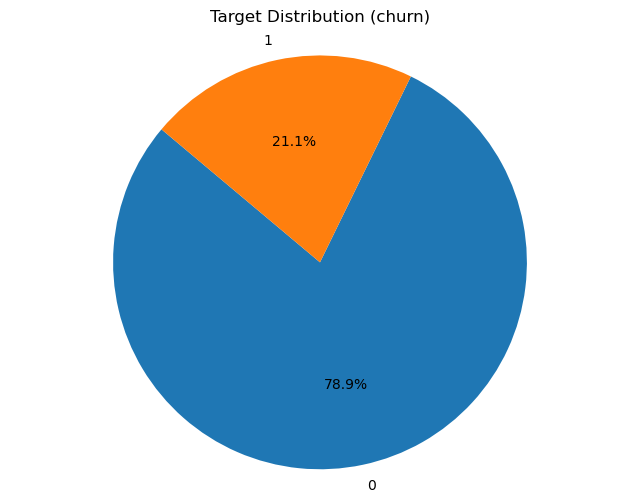

In [12]:
target_dist = df['churn'].value_counts()

labels = target_dist.index
sizes = target_dist.values

plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle = 140)
plt.title('Target Distribution (churn)')
plt.axis('equal')
plt.show()

In [13]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
count,41251.000000,41251.000000,41251.000000,41251.000000,41251.000000,41251.000000,41251.000000,41251.000000,41251.000000
mean,656.278733,38.061211,4.999030,55723.301201,1.554362,0.754382,0.496667,112303.655728,0.211268
std,80.062353,8.801304,2.802899,62859.325180,0.545635,0.430458,0.499995,50369.838886,0.408213
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,598.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74580.800000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117036.380000,0.000000
75%,710.000000,42.000000,7.000000,120165.450000,2.000000,1.000000,1.000000,154775.700000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [14]:
df_input = df.drop('churn', axis = 1)
df_output = df['churn']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size = 0.2, random_state = 42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(33000, 10)
(8251, 10)
(33000,)
(8251,)


Encoding (Train & Test)

In [16]:
df['Geography'].unique()

array(['France', 'Germany', 'Spain'], dtype=object)

In [17]:
x_train['Geography'].value_counts()

France     18764
Spain       7295
Germany     6941
Name: Geography, dtype: int64

In [18]:
x_train['Geography'].replace({'France': 0, 'Spain': 1, 'Germany': 2}, inplace=True)

x_train = pd.get_dummies(x_train, columns = ['Geography'], prefix = 'Geography')

convert_int = ['Geography_France', 'Geography_Germany', 'Geography_Spain']
x_train[convert_int] = x_train[convert_int].astype(int)

In [19]:
x_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
10482,691.0,0,Male,43.0,2,0.00,2,1,1,131284.92
26630,750.0,2,Female,55.0,7,133871.19,1,1,0,53949.71
12736,709.0,0,Female,52.0,7,161889.79,1,0,1,18761.92
4381,749.0,0,Male,38.0,7,0.00,2,1,1,149474.69
41121,512.0,0,Female,42.0,6,117436.36,1,1,0,155047.73


In [20]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [21]:
gender_encode = {'Male':0, 'Female': 1}
x_train['Gender'] = x_train['Gender'].map(gender_encode)

In [22]:
x_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
10482,691.0,0,0,43.0,2,0.00,2,1,1,131284.92
26630,750.0,2,1,55.0,7,133871.19,1,1,0,53949.71
12736,709.0,0,1,52.0,7,161889.79,1,0,1,18761.92
4381,749.0,0,0,38.0,7,0.00,2,1,1,149474.69
41121,512.0,0,1,42.0,6,117436.36,1,1,0,155047.73


Testing Encode

x_test = pd.get_dummies(x_test, columns = ['Geography'], prefix = 'Geography')

x_test[convert_int] = x_test[convert_int].astype(int)

In [23]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8251 entries, 18359 to 40020
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      8251 non-null   float64
 1   Geography        8251 non-null   object 
 2   Gender           8251 non-null   object 
 3   Age              8251 non-null   float64
 4   Tenure           8251 non-null   int64  
 5   Balance          8251 non-null   float64
 6   NumOfProducts    8251 non-null   int64  
 7   HasCrCard        8251 non-null   int64  
 8   IsActiveMember   8251 non-null   int64  
 9   EstimatedSalary  8251 non-null   float64
dtypes: float64(4), int64(4), object(2)
memory usage: 709.1+ KB


In [24]:
x_test['Geography'].replace({'France': 0, 'Spain': 1, 'Germany': 2}, inplace=True)

In [25]:
x_test['Gender'] = x_test['Gender'].map(gender_encode)

In [26]:
x_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
18359,599.0,2,1,56.0,6,102773.20,1,1,1,37266.43
1465,828.0,1,1,36.0,1,122793.96,2,1,0,99341.87
29591,684.0,2,0,26.0,5,87098.91,1,0,0,106095.82
729,520.0,0,1,28.0,1,121197.64,1,1,1,72577.33
7304,637.0,2,0,37.0,7,126477.43,1,0,0,70954.87


Scaling

In [27]:
scaler = RobustScaler()
scale_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

x_train[scale_cols] = scaler.fit_transform(x_train[scale_cols])

In [28]:
x_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
10482,0.285714,0,0,0.6,-0.75,0.000000,0.0,1,1,0.168111
26630,0.812500,2,1,1.8,0.50,1.110097,-1.0,1,0,-0.798186
12736,0.446429,0,1,1.5,0.50,1.342435,-1.0,0,1,-1.237854
4381,0.803571,0,0,0.1,0.50,0.000000,0.0,1,1,0.395391
41121,-1.312500,0,1,0.5,0.25,0.973815,-1.0,1,0,0.465025


In [29]:
x_test[scale_cols]= scaler.transform(x_test[scale_cols])

In [30]:
x_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
18359,-0.535714,2,1,1.9,0.25,0.852224,-1.0,1,1,-1.006642
1465,1.508929,1,1,-0.1,-1.00,1.018241,0.0,1,0,-0.231015
29591,0.223214,2,0,-1.1,0.00,0.722248,-1.0,0,0,-0.146625
729,-1.241071,0,1,-0.9,-1.00,1.005004,-1.0,1,1,-0.565435
7304,-0.196429,2,0,0.0,0.50,1.048786,-1.0,0,0,-0.585708


In [31]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20]
}
rf_classifier = RandomForestClassifier(random_state = 42)

grid_search = GridSearchCV(estimator = rf_classifier, param_grid = param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 10, 'n_estimators': 300}
Best Score: 0.8621212121212121


In [32]:
best_rf_classifier = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 42)
best_rf_classifier.fit(x_train, y_train)
y_rf_pred = best_rf_classifier.predict(x_test)

print("Accuracy: ", accuracy_score(y_test, y_rf_pred))
print("\nClassification Report:\n", classification_report(y_test, y_rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_rf_pred))

Accuracy:  0.8614713368076596

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      6519
           1       0.75      0.52      0.61      1732

    accuracy                           0.86      8251
   macro avg       0.81      0.73      0.76      8251
weighted avg       0.85      0.86      0.85      8251

Confusion Matrix:
 [[6214  305]
 [ 838  894]]


In [33]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'gamma': [0, 0.1, 0.2]
}
xgb_classifier = XGBClassifier(random_state = 42)
grid_search = GridSearchCV(estimator = xgb_classifier, param_grid = param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'gamma': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best Score: 0.8617575757575757


In [34]:
best_xgb_classifier = XGBClassifier(n_estimators = 100, max_depth = 3, gamma = 0, random_state = 42)
best_xgb_classifier.fit(x_train, y_train)
y_xgb_pred = best_xgb_classifier.predict(x_test)

print("Accuracy: ", accuracy_score(y_test, y_xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, y_xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_xgb_pred))

Accuracy:  0.8645012725730215

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      6519
           1       0.74      0.55      0.63      1732

    accuracy                           0.86      8251
   macro avg       0.81      0.75      0.77      8251
weighted avg       0.86      0.86      0.86      8251

Confusion Matrix:
 [[6173  346]
 [ 772  960]]


In [35]:
with open('gender_encode.pkl', 'wb') as file:
    pkl.dump(gender_encode, file)

In [36]:
with open('best_rf_classifier.pkl', 'wb') as file:
    pkl.dump(best_rf_classifier, file)

In [37]:
with open('robust_scaler.pkl', 'wb') as file:
    pkl.dump(scaler, file)